<a href="https://colab.research.google.com/github/hamidbekam9193-ui/Lectures/blob/main/TS_DT_Intuition_v3_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Decision Tree Regression for Time Series Forecasting
##From Theory and Manual Calculation to Visualization


## 1. Introduction

This document provides a comprehensive guide to building a Decision Tree regression model for time series forecasting using the full airline passenger dataset. We will use two lagged features (`Lag_1` and `Lag_2`) to predict future passenger numbers.

The tutorial is structured to cover: 1. **Data Preparation:** Loading the data and creating lagged features. 2. **Model Building:** Fitting a decision tree using R's `rpart` package. 3. **Algorithm Calculation:** A manual, step-by-step walkthrough of the math behind the tree's decisions. 4. **Visualization:** Creating a scatter plot to visualize how the decision tree partitions the data.

## 2. Setup and Data Preparation

First, we load the necessary libraries and prepare the data. This involves loading the dataset from a URL, creating `Lag_1` and `Lag_2` features, and removing the initial rows that have missing values due to the lagging process.


![](https://raw.githubusercontent.com/hamidb201214-svg/Lectures/refs/heads/main/Econometrics/data/plots/TS_DT_1.png)

In [ ]:
install.packages("zoo")
install.packages("rpart.plot")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Load necessary libraries
library(tidyverse)
library(zoo)
library(rpart)
library(rpart.plot)

# Load the dataset from the URL
url <- "https://raw.githubusercontent.com/hamidb201214-svg/Lectures/refs/heads/main/Econometrics/data/AirPassengers.csv"
passengers_data <- read_csv(url, show_col_types = FALSE)

# Rename the '#Passengers' column to 'Passengers'
passengers_data <- passengers_data %>%
  rename(Passengers = `#Passengers`)

# Convert Month to a time-based format and create lag features
passengers_data <- passengers_data %>%
  mutate(Month = as.yearmon(Month)) %>%
  arrange(Month) %>%
  mutate(
    Lag_1 = lag(Passengers, 1),
    Lag_2 = lag(Passengers, 2)
  ) %>%
  na.omit() # Drop the first two rows with NA values

# Glimpse the final prepared data
glimpse(passengers_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Rows: 142
Columns: 4
$ Month      <yearmon> Mar 1949, Apr 1949, May 1949, Jun 1949, Jul 1949, Aug 1…
$ Passengers <dbl> 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126,…
$ Lag_1      <dbl> 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,…
$ Lag_2      <dbl> 112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118,…


## 3. Building the Decision Tree Model

Next, we fit an `rpart` model with a `maxdepth` of 2. The model will learn to predict `Passengers` using `Lag_1` and `Lag_2`. The printed summary is crucial, as it tells us exactly which features and values were chosen for the decision boundaries.


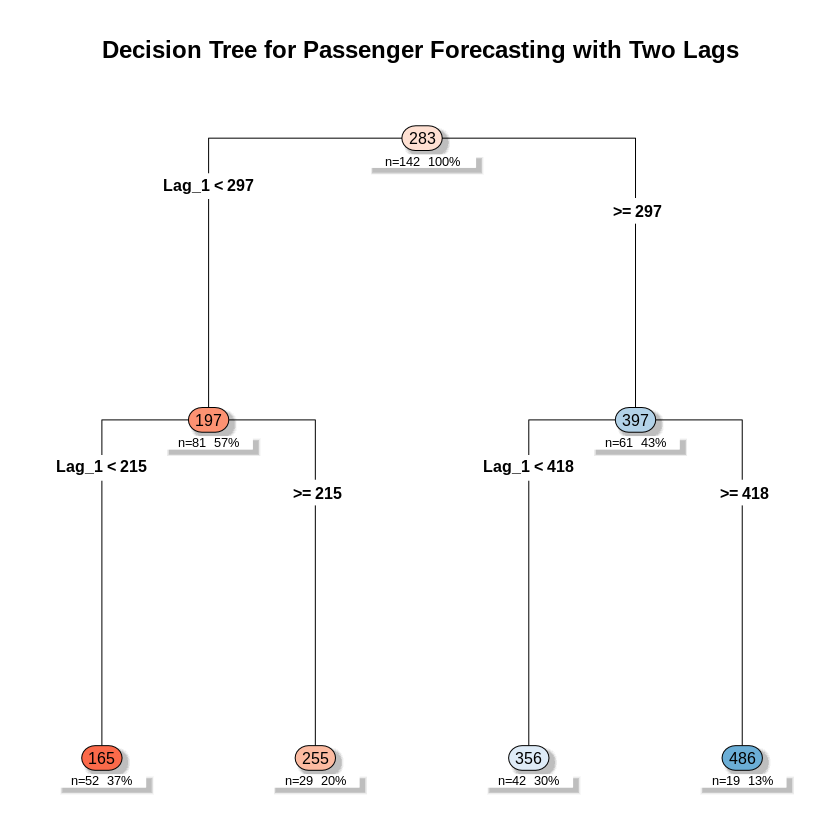

In [ ]:
# Define control parameters for the tree
control_params <- rpart.control(maxdepth = 2)

# Building the decision tree model using both Lag1 and Lag2
# Note: The data is already prepared in the previous chunk
model <- rpart(Passengers ~ Lag_1 + Lag_2, data = passengers_data, method = "anova", control = control_params)

# Plotting the decision tree
rpart.plot(model, type = 4, extra = 101, under = TRUE, cex = 0.8,
           main = "Decision Tree for Passenger Forecasting with Two Lags",
           fallen.leaves = TRUE,
           branch = 1,
           box.palette = "RdBu",
           shadow.col = "gray",
           border.col = "black")

# # Print the detailed summary of the tree
# print(summary(model))

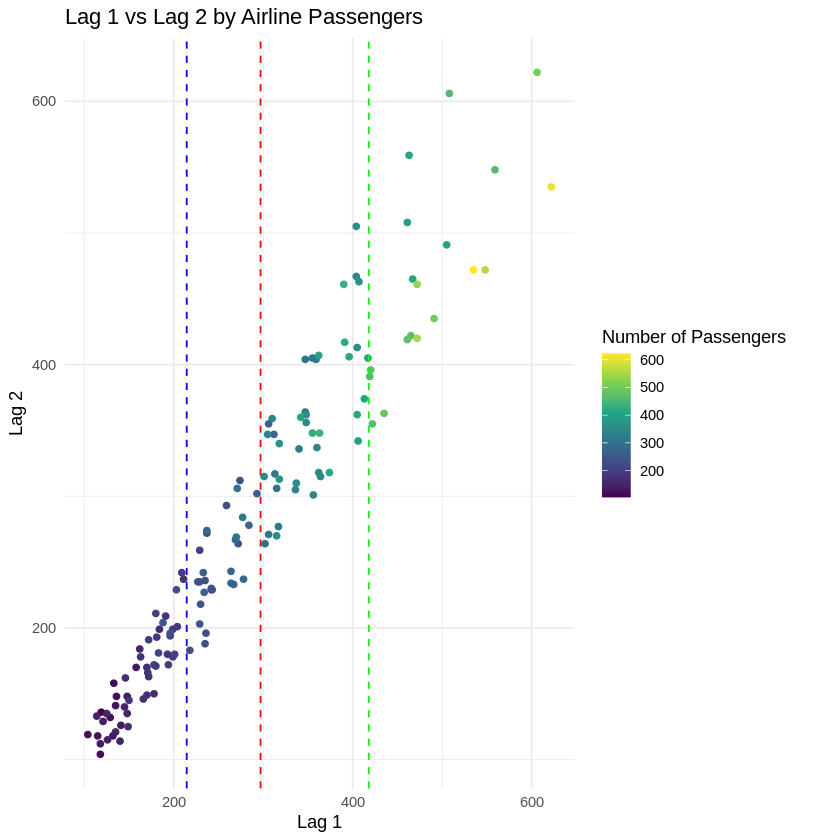

In [ ]:
library(ggplot2)
ggplot(passengers_data, aes(x = Lag_1, y = Lag_2, color = Passengers)) +
  geom_point() +
  scale_color_viridis_c() +
  geom_vline(xintercept = 297, color = 'red', linetype = 'dashed') +
  geom_vline(xintercept = 214.5, color = 'blue', linetype = 'dashed') +
  geom_vline(xintercept = 418, color = 'green', linetype = 'dashed') +
  labs(
    title = 'Lag 1 vs Lag 2 by Airline Passengers',
    x = 'Lag 1',
    y = 'Lag 2',
    color = 'Number of Passengers'
  ) +
  theme_minimal()

## 4. Algorithm Calculation: A Step-by-Step Walkthrough

How did the algorithm decide that **`Lag_1 < 297`** was the best first split? It did so by calculating the **Standard Deviation Reduction (SDR)** for all possible splits on all available features (`Lag_1` and `Lag_2`) and choosing the one that maximized this value. The ID3 algorithm for regression trees follows these steps:

-   **Step 1: Calculate the Initial Standard Deviation (SD of the Parent):** A measure of the data's dispersion. We use it to quantify the variability of `Passengers`.
  $SD(Y) = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (Y_i - \bar{Y})^2}$

-   **Step 2: Evaluate Potential Splits and Calculate Their SDR:** The metric used to decide the best split. The algorithm calculates the SDR for every possible split on *every feature* and chooses the split that maximizes this value.

    $SDR = SD(Parent) - \left( \frac{n_1}{n} \cdot SD(\text{Group } 1) + \frac{n_2}{n} \cdot SD(\text{Group } 2) \right)$

-   **Step 3: Choose the Best Split & Repeat**

Let's walk through the calculations to see why this split was chosen over others.

### Step 1: Calculate the Initial Standard Deviation (SD of the Parent)

First, we need the standard deviation of our target variable, `Passengers`, for the entire dataset. This represents the total variability before any splits are made and serves as our baseline.

In [ ]:
# Store the parent SD in a variable for reuse
sd_parent <- sd(passengers_data$Passengers)
n_total <- nrow(passengers_data)
cat("Total Observations (n):", n_total, "\n")
cat("Initial Standard Deviation (Parent SD):", sd_parent, "\n")

Total Observations (n): 142 
Initial Standard Deviation (Parent SD): 119.1759 


Our starting SD is **\~120.0**. A good split will create subgroups with much lower weighted-average standard deviations.

### Step 2: Evaluate Potential Splits and Calculate Their SDR

The algorithm now exhaustively tests splits. Let's compare three of them:

-   **Split A (The Winner):** `Lag_1 < 297`
-   **Split B (Suboptimal on `Lag_1`):** `Lag_1 < 200`
-   **Split C (A Split on `Lag_2`):** `Lag_2 < 250`

------------------------------------------------------------------------

#### **Split A: `Lag_1 < 297`**

This is the split that `rpart` identified as the best one.

**1. Calculate Group Statistics:**


In [ ]:
groupA1 <- passengers_data$Passengers[passengers_data$Lag_1 < 297]
groupA2 <- passengers_data$Passengers[passengers_data$Lag_1 >= 297]
n_A1 <- length(groupA1)
n_A2 <- length(groupA2)
sd_A1 <- sd(groupA1)
sd_A2 <- sd(groupA2)

cat("Group 1 (Lag_1 < 297): n =", n_A1, ", SD =", sd_A1, "\n")
cat("Group 2 (Lag_1 >= 297): n =", n_A2, ", SD =", sd_A2, "\n")

Group 1 (Lag_1 < 297): n = 81 , SD = 54.1141 
Group 2 (Lag_1 >= 297): n = 61 , SD = 79.52618 


**2. Calculate SDR with a Single Line of R Code:**

In [ ]:
sdr_A <- sd_parent - ((n_A1 / n_total) * sd_A1 + (n_A2 / n_total) * sd_A2)
cat("SDR for Split A:", sdr_A, "\n")

SDR for Split A: 54.14538 


**3. Manual Formula Calculation:**
$$ SDR = SD_{parent} - \left( \frac{n_1}{n} \cdot SD_{group1} + \frac{n_2}{n} \cdot SD_{group2} \right) $$

$$ SDR_A = 120.0 - \left( \frac{81}{142} \cdot 54.11 + \frac{61}{142} \cdot 79.53 \right) $$

$$ SDR_A = 120.0 - (0.570 \cdot 54.11 + 0.430 \cdot 79.53) $$

$$ SDR_A = 120.0 - (30.56 + 33.92) = 120.0 - 64.48 = \mathbf{54.52} $$

------------------------------------------------------------------------

#### **Split B: `Lag_1 < 200` (A Suboptimal Split on the Same Feature)**

Let's see what the SDR would be for a different, non-optimal split point on `Lag_1`.

**1. Calculate Group Statistics:**


![](https://raw.githubusercontent.com/hamidb201214-svg/Lectures/refs/heads/main/Econometrics/data/plots/TS_DT_2.png)

In [ ]:
groupB1 <- passengers_data$Passengers[passengers_data$Lag_1 < 200]
groupB2 <- passengers_data$Passengers[passengers_data$Lag_1 >= 200]
n_B1 <- length(groupB1)
n_B2 <- length(groupB2)
sd_B1 <- sd(groupB1)
sd_B2 <- sd(groupB2)

cat("Group 1 (Lag_1 < 200): n =", n_B1, ", SD =", sd_B1, "\n")
cat("Group 2 (Lag_1 >= 200): n =", n_B2, ", SD =", sd_B2, "\n")

Group 1 (Lag_1 < 200): n = 47 , SD = 32.35496 
Group 2 (Lag_1 >= 200): n = 95 , SD = 98.61333 


**2. Calculate SDR with a Single Line of R Code:**


In [ ]:
sdr_B <- sd_parent - ((n_B1 / n_total) * sd_B1 + (n_B2 / n_total) * sd_B2)
cat("SDR for Split B:", sdr_B, "\n")

SDR for Split B: 42.49319 


**3. Manual Formula Calculation:**
$$
SDR = SD_{parent} - \left( \frac{n_1}{n} \cdot SD_{group1} + \frac{n_2}{n} \cdot SD_{group2} \right)
$$
$$
SDR_A = 119.18 - \left( \frac{47}{142} \cdot 32.35 + \frac{95}{142} \cdot 98.61 \right)
$$
$$
SDR_A = 119.18 - (0.33 \cdot 32.35 + 0.67 \cdot 98.61)
$$
$$
SDR_A = 119.18 - (10.68 + 66.07) = 119.18 - 76.75 = \mathbf{42.43}
$$

------------------------------------------------------------------------

#### **Split C: `Lag_2 < 250` (A Split on the Other Feature)**

The algorithm must also check other features. Let's test a plausible split on `Lag_2`.

**1. Calculate Group Statistics:**

![](https://raw.githubusercontent.com/hamidb201214-svg/Lectures/refs/heads/main/Econometrics/data/plots/TS_DT_3.png)

In [ ]:
groupC1 <- passengers_data$Passengers[passengers_data$Lag_2 < 250]
groupC2 <- passengers_data$Passengers[passengers_data$Lag_2 >= 250]
n_C1 <- length(groupC1)
n_C2 <- length(groupC2)
sd_C1 <- sd(groupC1)
sd_C2 <- sd(groupC2)

cat("Group 1 (Lag_2 < 250): n =", n_C1, ", SD =", sd_C1, "\n")
cat("Group 2 (Lag_2 >= 250): n =", n_C2, ", SD =", sd_C2, "\n")

Group 1 (Lag_2 < 250): n = 69 , SD = 48.26507 
Group 2 (Lag_2 >= 250): n = 73 , SD = 89.67344 


**2. Calculate SDR with a Single Line of R Code:**

In [ ]:
sdr_C <- sd_parent - ((n_C1 / n_total) * sd_C1 + (n_C2 / n_total) * sd_C2)
cat("SDR for Split C:", sdr_C, "\n")

SDR for Split C: 49.62346 


**3. Manual Formula Calculation:**
$$
SDR = SD_{parent} - \left( \frac{n_1}{n} \cdot SD_{group1} + \frac{n_2}{n} \cdot SD_{group2} \right)
$$
$$
SDR_A = 119.18 - \left( \frac{69}{142} \cdot 48.27 + \frac{73}{142} \cdot 89.67 \right)
$$
$$
SDR_A = 119.18 - (0.49 \cdot 48.27 + 0.51 \cdot 89.67)
$$
$$
SDR_A = 119.18 - (23.45 + 46.10) = 119.18 - 69.55 = \mathbf{49.63}
$$

---




### Step 3: Choose the Best Split & Repeat

Now, we compare the SDR from each potential split.

-   **Split A (`Lag_1 < 297`):** SDR = **55.52**
-   **Split B (`Lag_1 < 200`):** SDR = 42.43
-   **Split D (`Lag_2 < 250`):** SDR = 49.63

The split **`Lag_1 < 297`** yields the highest Standard Deviation Reduction. This is precisely why the `rpart` algorithm selected it as the first and most important rule for partitioning the data.

The algorithm then **recursively** repeats this entire process on the two new subgroups (`Lag_1 < 297` and `Lag_1 >= 297`), finding the next best split within each one until the stopping criteria (like `maxdepth = 2`) are met.

## 5. Visualizing the Decision Boundaries

Now, we can visualize the splits from the model summary on a scatter plot. Each vertical line represents a decision rule from the tree. These lines partition the feature space into distinct rectangular regions.


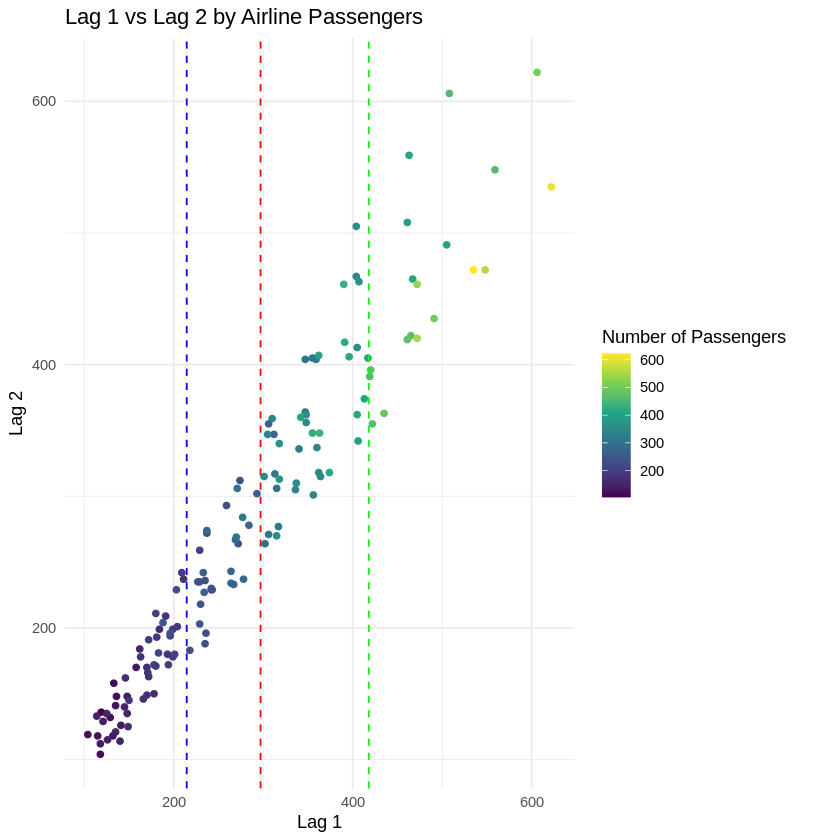

In [ ]:
library(ggplot2)
ggplot(passengers_data, aes(x = Lag_1, y = Lag_2, color = Passengers)) +
  geom_point() +
  scale_color_viridis_c() +
  geom_vline(xintercept = 297, color = 'red', linetype = 'dashed') +
  geom_vline(xintercept = 214.5, color = 'blue', linetype = 'dashed') +
  geom_vline(xintercept = 418, color = 'green', linetype = 'dashed') +
  labs(
    title = 'Lag 1 vs Lag 2 by Airline Passengers',
    x = 'Lag 1',
    y = 'Lag 2',
    color = 'Number of Passengers'
  ) +
  theme_minimal()

### How to Read the Plot

-   **Red Dashed Line (`x = 297`):** This is the root split, the most important rule. It separates the data into two main groups.

-   **Blue Dotted Line (`x = 214.5`):** This rule applies only to the data *left* of the red line, further dividing the lower-passenger group.

-   **Green Dotted Line (`x = 418`):** This rule applies only to the data *right* of the red line, splitting the higher-passenger group.